## Get started with Videos

__Description__:

This notebook demonstrates how to execute an adversarial attack on video data using HEART.

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load and prepare data
3. Load video classification model
4. Define the Projected Gradient Descent attack
5. Predict and visualize
6. MAITE tasks

## 1. Notebook imports
The following are the library imports for this notebook and a utility function for displaying videos as GIFs within the notebook

In [1]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from heart_library.estimators.classification import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack

from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch import tensor
from numpy.typing import NDArray
import numpy as np

from datasets import load_dataset
from io import BytesIO
from PIL import Image
import IPython.display as display

def to_gif(video: np.ndarray, mul_pixels: bool = False) -> None:
    """Convert video to gif
    
    :param video: video to convert to gif, expected in format NCFHW
    :param mul_pixels: boolean indicating if video pixels range should increase
    :return None
    """
    if mul_pixels:
        frames = [Image.fromarray(frame.transpose(1, 2, 0)) for frame in (video[0].transpose(1, 0, 2, 3)*255).astype(np.uint8)]
    else:
        frames = [Image.fromarray(frame.transpose(1, 2, 0)) for frame in (video[0].transpose(1, 0, 2, 3)).astype(np.uint8)]

    gif_data = BytesIO()
    frames[0].save(gif_data, format='GIF', save_all=True, append_images=frames[1:], loop=0, duration=100)
    gif_data.seek(0)
    display.display(display.Image(data=gif_data.read()))

## 2. Load and prepare data
The next step is to load a video dataset. Here we are loading a small sample of example "eating" videos. As the model we wish to use, the [r3d_18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r3d_18.html) was trained using the [Kinetics Human Action Video Dataset](https://arxiv.org/abs/1705.06950). 

The data is transformed as per the specifications of the model noted in documentation on Torchvision. Specifically, resizing, cropping and ensuring the pixel range is between 0 and 1.

The data is transformed to conform to shape `NCFHW` where:
- N: Number, or batch of videos
- F: Frames, the number of frames in the video
- C: Channels, generally 3 for RGB, 1 for grayscale
- H: Height dim of the video
- W: Width dim of the video

In [ ]:
data = load_dataset("linoyts/wan_eating", split="train[:4]")

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 171), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
])

def preprocess(video_reader, start_frame=0, end_frame=80):
    frames = video_reader.get_batch(range(start_frame, end_frame))
    frames = frames.asnumpy()
    frames = (frames / 255)
    resized_frames = np.asarray(list(map(lambda frame: resize(frame), frames)))
    resized_frames = resized_frames.transpose(1,0,2,3) # should be in format ... C, F, H, W
    return resized_frames

sample_data = []
for item in data:
    preproc_vid = preprocess(item['video'])
    sample_data.append(preproc_vid)
sample_data: NDArray[np.float32] = np.asarray(sample_data)

objc[56123]: Class AVFFrameReceiver is implemented in both /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x3312e03a8) and /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x3363d0a10). One of the two will be used. Which one is undefined.
objc[56123]: Class AVFAudioReceiver is implemented in both /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x3312e03f8) and /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x3363d0a60). One of the two will be used. Which one is undefined.


## 3. Load video classification model

The `r3d_18` model unfortunately expects data in a different format to AdversarialPatchPyTorch attack and so we will need to create a model wrapper to transform the data prior to the forward pass. This can easily be achieved with the following cell. Note that `x` is a tensor and so we permute the correct dimension for passing to the model.

Once wrapped, we can instantiate our `JaticPyTorchClassifier`. Key to note here is the input shape, which has an extra dimension due to the time (frame) included in videos - here we are cropping videos (i.e. our data) to have 80 frames. The model was trained on `KINETICS400_V1` and so we expect 400 class labels. 

In [3]:
weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
_ = model.eval()

jptc = JaticPyTorchClassifier(model=model, nb_classes=400, input_shape=(3, 80, 112, 112), loss=CrossEntropyLoss(), clip_values=(0,1),
                                     device_type="cpu")

## 4. Define the Projected Gradient Descent attack

Next, we define the attack: Projected Gradient Descent and its associated parameters.
> Hint: you can reduce the eps and esp_step values to add nunace to the perturbations and make them less noticeable!

In [4]:
attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=0.2, eps_step=0.01, targeted=False, verbose=True)
augmentation = JaticAttack(attack)

adv_videos, y, meta = augmentation(sample_data)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Predict and visualize

The following cell executes model prediction on the original, benign videos. 
The video, its predicted label and confidence are printed.

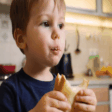

Predicted eating burger with 35.04% confidence.


In [5]:
predictions = jptc(sample_data)

probs = softmax(tensor(np.asarray(predictions)), dim=1)
label = probs[1].argmax().item()
probs = probs[1][label]*100
to_gif(sample_data[[1]], mul_pixels=True)
print(f"Predicted {weights.meta['categories'][label]} with {probs:.2f}% confidence.")

The following cell executes model prediction on the `adversarial` videos. 
The video, its predicted label and confidence are printed.
> Note that the predicted class label has now changed

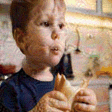

Predicted playing cymbals with 100.00% confidence.


In [6]:
predictions = jptc(np.asarray(adv_videos))

probs = softmax(tensor(np.asarray(predictions)), dim=1)
label = probs[1].argmax().item()
probs = probs[1][label]*100
to_gif(np.asarray(adv_videos)[[1]], mul_pixels=True)
print(f"Predicted {weights.meta['categories'][label]} with {probs:.2f}% confidence.")

## 6. MAITE tasks

In this section we will demonstrate how to use video data, HEART and two MAITE tasks: predict and evaluate. 

In order to run these two tasks, MAITE expects either a dataset or a dataloader. Therefore, we first create a dataset wrapper for the video data.

In [7]:
from maite.protocols import DatumMetadata, DatasetMetadata, ArrayLike
from maite.protocols.image_classification import DatumMetadataType
from typing import Optional

class VideoDatumMeta(DatumMetadata):
    """Video dataum metadata"""
    id: str

class VideoDataset:
    """Video dataset"""
    def __init__(self, data: NDArray[np.float32], labels: Optional[list[int]] = None) -> None:
        """Init dataset"""
        self.data = data
        if not labels:
            self.labels = [24, 109, 109, 131]
        self.metadata = DatasetMetadata({"id": "example", "index2label": {1: "label"}})

    def __len__(self) -> int:
        """Len of dataset"""
        return len(self.data)

    def __getitem__(self, ind: int) -> tuple[ArrayLike, ArrayLike, DatumMetadataType]:
        """Get item"""
        image: NDArray[np.float32] = self.data[ind]
        label: NDArray[np.int32] = np.array([self.labels[ind]])
        return (image, label, VideoDatumMeta({"id": "example"}))

dataset = VideoDataset(data=sample_data)

Now that we have our video dataset, we can call the ```predict``` task from MAITE. We pass our video classification model, dataset and a batch size with which to execute.


Note how the predictions differ when an attack augmentation is added in the second ```predict``` task execution - this task is executing the attack, generating adversarial samples and running model predictions on the perturbed data.

In [36]:
from maite.tasks import predict

predictions = predict(model=jptc, dataset=dataset, batch_size=2)
labels = [weights.meta['categories'][element] for row in np.argmax(np.asarray(predictions[0]), axis=2) for element in row]
print("Benign predictions", labels)

adv_predictions = predict(model=jptc, dataset=dataset, augmentation=augmentation, batch_size=2)
adv_labels = [weights.meta['categories'][element] for row in np.argmax(np.asarray(adv_predictions[0]), axis=2) for element in row]
print("Adversarial predictions", adv_labels)

  0%|          | 0/2 [00:00<?, ?it/s]

Benign predictions ['blowing glass', 'eating burger', 'eating burger', 'folding clothes']


  0%|          | 0/2 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial predictions ['eating spaghetti', 'playing cymbals', 'wrapping present', 'smoking hookah']


Next up, we will run the MAITE ```evaluate``` task. This task takes an additional ```metric```. In this case, we use macro multi-class classification.


In the second call, we add the attack augmentation which is first run before calculating metrics on model predictions. Note the drop in performance when an attack augmentation is added.

In [10]:
from heart_library.metrics import HeartAccuracyMetric
from maite.tasks import evaluate

acc_args = {"task": "multiclass", "num_classes": 400, "average": "macro"}
metric = HeartAccuracyMetric(**acc_args)


benign_result = evaluate(model=jptc, dataset=dataset, metric=metric, batch_size=2)
print("Benign result", benign_result)

adv_result = evaluate(model=jptc, dataset=dataset, augmentation=augmentation, metric=metric, batch_size=2)
print("Adversarial result", adv_result)

  0%|          | 0/2 [00:00<?, ?it/s]

Benign result ({'accuracy': 1.0}, [], [])


  0%|          | 0/2 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial result ({'accuracy': 0.0}, [], [])
